In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [19]:
# Dataset config
# TIME_BEG = 1451606400 # = year 2016
TIME_BEG = 1546347600 # = year 2019
TIME_INTERVAL = 60 # minutes
NUM_ENCODE_TIME_STEPS = 72
NUM_DECODE_TIME_STEPS = 3

In [20]:
prices = None

with open('kaggle_1min.csv', 'r') as f:
    reader = csv.reader(f)
    prices = list(reader)

In [21]:
# Process with Panda dataframe
prices_df = pd.DataFrame(prices[1:], columns=prices[0])

print("Original dataframe: ", prices_df)

prices_df = prices_df.drop(columns=["Open", "High", "Low", "Close", "Volume_(Currency)"])
prices_df = prices_df.astype(float)
prices_df = prices_df.fillna(0) # Replace NaN with 0 (time where trade volume = 0)
prices_df = prices_df.loc[prices_df["Timestamp"] >= TIME_BEG] # Cut off from desired begin time
prices_df = prices_df.reset_index(drop=True)

print("Processed dataframe: ", prices_df)

Original dataframe:            Timestamp      Open      High       Low     Close Volume_(BTC)  \
0        1325317920      4.39      4.39      4.39      4.39   0.45558087   
1        1325317980       NaN       NaN       NaN       NaN          NaN   
2        1325318040       NaN       NaN       NaN       NaN          NaN   
3        1325318100       NaN       NaN       NaN       NaN          NaN   
4        1325318160       NaN       NaN       NaN       NaN          NaN   
...             ...       ...       ...       ...       ...          ...   
4727772  1609372560  28801.47  28829.42  28785.64  28829.42   0.96522104   
4727773  1609372620  28829.42   28863.9  28829.42  28857.06   2.36883117   
4727774  1609372680  28850.49  28900.52  28850.49  28882.82   2.46658976   
4727775  1609372740  28910.54  28911.52   28867.6   28881.3     7.332773   
4727776  1609372800  28893.21  28928.49  28893.21  28928.49   5.75767938   

        Volume_(Currency) Weighted_Price  
0            2.00000001

In [22]:
# Summarize prices by each TIME_INTERVAL using Volume Weighted Average Price (VWAP) calculations
prices_tensor = torch.from_numpy(prices_df.values)
shape = (prices_tensor.shape[0] // TIME_INTERVAL, 2)
condensed_prices_tensor = torch.empty(shape)

j = 0
for i in range(0, prices_tensor.shape[0] - TIME_INTERVAL, TIME_INTERVAL):
    condensed_prices_tensor[j, 0] = prices_tensor[i, 0] # Time stamp

    # Calculate WVAP
    volume_weighted_sum = torch.sum(prices_tensor[i:i+TIME_INTERVAL, 1] * prices_tensor[i:i+TIME_INTERVAL, 2])
    total_volume = torch.sum(prices_tensor[i:i+TIME_INTERVAL, 1])
    wvap = volume_weighted_sum / total_volume

    # If no trade in this time interval use the price in the previous one
    # Here assume that first TIME_INTERVAL since TIME_BEG has > 0 trade volume
    if total_volume == 0:
        condensed_prices_tensor[j, 1] = condensed_prices_tensor[j-1, 1]
    else:
        condensed_prices_tensor[j, 1] = wvap
    
    j += 1
    
print("Original price data shape: ", prices_tensor.shape)
print("Time condensed price data shape: ", condensed_prices_tensor.shape)
print("Condensed price data: \n", condensed_prices_tensor)

Original price data shape:  torch.Size([1050421, 3])
Time condensed price data shape:  torch.Size([17507, 2])
Condensed price data: 
 tensor([[1.5463e+09, 3.7220e+03],
        [1.5464e+09, 3.6982e+03],
        [1.5464e+09, 3.6811e+03],
        ...,
        [1.6094e+09, 2.8804e+04],
        [1.6094e+09, 2.8800e+04],
        [1.6094e+09, 2.8817e+04]])


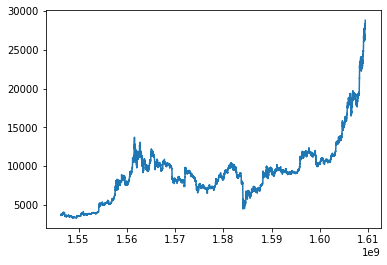

In [23]:
plt.plot(condensed_prices_tensor[:,0], condensed_prices_tensor[:,
1], label="Prices")

In [24]:
# Make input time serie data and target time serie data tensor 
X_shape = (condensed_prices_tensor.shape[0] - NUM_ENCODE_TIME_STEPS - NUM_DECODE_TIME_STEPS, NUM_ENCODE_TIME_STEPS)
y_shape = (condensed_prices_tensor.shape[0] - NUM_ENCODE_TIME_STEPS - NUM_DECODE_TIME_STEPS, NUM_DECODE_TIME_STEPS)

X = torch.empty(X_shape)
y = torch.empty(y_shape)

# # Raw price
# for i in range(X.shape[0]):
#     input_end_i = i + NUM_ENCODE_TIME_STEPS
#     target_end_i = input_end_i + NUM_DECODE_TIME_STEPS
#     X[i] = condensed_prices_tensor[i:input_end_i, 1]
#     y[i] = condensed_prices_tensor[input_end_i:target_end_i, 1]

# Change from last time step (more numerically stable for the neural net)
for i in range(X.shape[0]):
    serie_end_i = i + NUM_ENCODE_TIME_STEPS + NUM_DECODE_TIME_STEPS
    time_serie = (condensed_prices_tensor[i+1:serie_end_i+1, 1] - condensed_prices_tensor[i:serie_end_i, 1]) / condensed_prices_tensor[i:serie_end_i, 1]
    X[i] = time_serie[:NUM_ENCODE_TIME_STEPS]
    y[i] = time_serie[NUM_ENCODE_TIME_STEPS:]

# Change in percentage
X = X * 100
y = y * 100

print("Encode time serie data shape:", X_shape)
print("Decode time serie data shape:", y_shape)
print("Training X:\n", X)
print("Training y:\n", y)

Encode time serie data shape: (17432, 72)
Decode time serie data shape: (17432, 3)
Training X:
 tensor([[-0.6389, -0.4636,  0.1499,  ...,  0.1761, -0.2977, -0.0685],
        [-0.4636,  0.1499, -0.0596,  ..., -0.2977, -0.0685, -0.4742],
        [ 0.1499, -0.0596, -0.7452,  ..., -0.0685, -0.4742, -0.3503],
        ...,
        [ 1.3356, -2.1918, -1.5066,  ..., -0.2167,  0.4175,  0.6655],
        [-2.1918, -1.5066,  1.2102,  ...,  0.4175,  0.6655,  1.2516],
        [-1.5066,  1.2102,  0.0964,  ...,  0.6655,  1.2516,  0.2138]])
Training y:
 tensor([[-0.4742, -0.3503,  0.2507],
        [-0.3503,  0.2507,  0.2644],
        [ 0.2507,  0.2644, -0.1068],
        ...,
        [ 1.2516,  0.2138, -0.0307],
        [ 0.2138, -0.0307, -0.0124],
        [-0.0307, -0.0124,  0.0582]])


In [25]:
print(X.shape)
print("Average absolute price change in", TIME_INTERVAL, "minutes", torch.mean(X))
print("Maximum price change in", TIME_INTERVAL, "minutes", torch.max(X))
print("Minimum price change in", TIME_INTERVAL, "minutes", torch.min(X))

torch.Size([17432, 72])
Average absolute price change in 60 minutes tensor(0.0135)
Maximum price change in 60 minutes tensor(13.9058)
Minimum price change in 60 minutes tensor(-13.0056)


In [26]:
# Checking for nan data
assert(torch.sum(X != X) == 0)
assert(torch.sum(y != y) == 0)

In [27]:
torch.save(X, "./../X.pt")
torch.save(y, "./../y.pt")